In [32]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [33]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [34]:

responses = []

with bz2.BZ2File('/Users/gost1/Desktop/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:07, 2973.45it/s]



Посмотрим на пример отзыва:

In [4]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

In [142]:
df = pd.DataFrame(responses)

In [87]:
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


## Часть 1. Анализ текстов


# Посчитайте количество отзывов в разных городах и на разные банки

In [22]:
df_city = df.groupby(['city']).text.count().reset_index()
df_city = df_city.sort_values('text', ascending=False)
df_city.head()

,city,text
2175,г. Москва,55354
3568,г. Санкт-Петербург,14342
1034,г. Екатеринбург,2337
2785,г. Новосибирск,2300
2672,г. Нижний Новгород,1976


In [23]:
df_city = df.groupby(['bank_name']).text.count().reset_index()
df_city = df_city.sort_values('text', ascending=False)
df_city.head()

,bank_name,text
502,Сбербанк России,26327
34,Альфа-Банк,10224
106,ВТБ 24,8185
482,Русский Стандарт,7943
625,Хоум Кредит Банк,7549


## Постройте гистограмы длин слов в символах и в словах

In [143]:
df["text"] = df["text"].str.lower()

In [64]:
symbols = df['text'].str.len()

<AxesSubplot:>

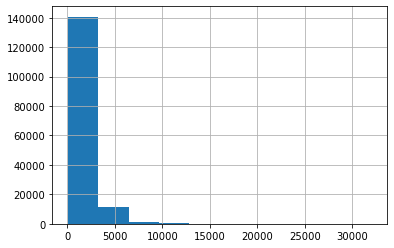

In [65]:
symbols.hist()

In [36]:
words = df['text'].str.split().str.len()

<AxesSubplot:>

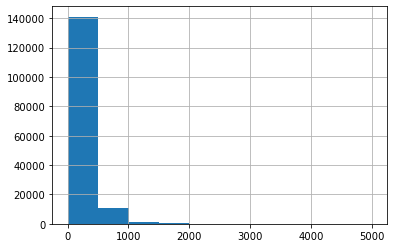

In [37]:
words.hist()

## Найдите 10 самых частых:

In [35]:
from string import punctuation
from nltk.tokenize import word_tokenize
punctuation
from collections import Counter

In [36]:
from collections import Counter
corpus = [token for tweet in df.text for token in word_tokenize(tweet) if token not in punctuation]

In [37]:
popular_words = Counter(corpus)
popular_words.most_common(10)

[('в', 1169557),
 ('и', 980761),
 ('не', 816419),
 ('на', 638715),
 ('что', 603171),
 ('я', 443478),
 ('с', 428021),
 ('по', 338743),
 ('мне', 293980),
 ('банка', 235176)]

In [38]:
from nltk.corpus import stopwords
stop = set(stopwords.words('russian'))

In [39]:
up = ['``', '\'\'','...']
noise = stopwords.words('russian') + list(punctuation) + up

In [40]:
without_stop_words = [token for token in corpus if token not in noise] 

In [41]:
popular_words = Counter(without_stop_words)
popular_words.most_common(10)

[('банка', 235176),
 ('банк', 159569),
 ('это', 158915),
 ('В', 152959),
 ('Я', 130418),
 ('деньги', 121778),
 ('карту', 101181),
 ('карты', 99040),
 ('день', 74627),
 ('И', 73724)]

In [42]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [44]:
word_lemm = [morph.parse(token)[0].normal_form for token in without_stop_words]

In [45]:
popular_words = Counter(word_lemm)
popular_words.most_common(10)

[('банк', 624274),
 ('карта', 331816),
 ('я', 201556),
 ('это', 200500),
 ('деньга', 178338),
 ('мой', 174129),
 ('день', 172636),
 ('в', 156374),
 ('кредит', 154865),
 ('который', 148990)]

In [53]:
len(word_lemm)

24799295

In [ ]:
#я урежу кол-во данных т. к. мой ПК не способен проработать такой цикл 

In [54]:
word_lemm1 = word_lemm[:1000000]

In [55]:
len(word_lemm1)

1000000

In [56]:
def filter(word):
    w  = morph.parse(word)[0].tag.POS
    if 'NOUN' == w:
        return word
    else:
        pass

In [57]:
total = [token for token in word_lemm1 if filter(token)]

In [50]:
morph.parse('карта')[0].tag.POS

'NOUN'

In [58]:
popular_words = Counter(total)
popular_words.most_common(10)

[('банк', 27389),
 ('карта', 13350),
 ('кредит', 6940),
 ('день', 6936),
 ('деньга', 6500),
 ('сотрудник', 6472),
 ('клиент', 5432),
 ('счёт', 5315),
 ('сумма', 4798),
 ('отделение', 4717)]

## Постройте кривые Ципфа и Хипса

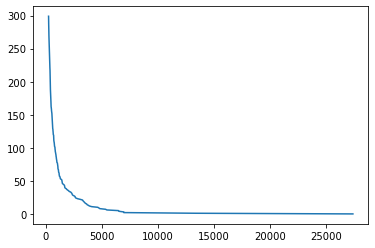

In [61]:
freqs = list(popular_words.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

In [68]:
from tqdm import tqdm

cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = word_tokenize(row['text'])
    cnt.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))

100%|██████████| 153499/153499 [50:24<00:00, 50.76it/s]


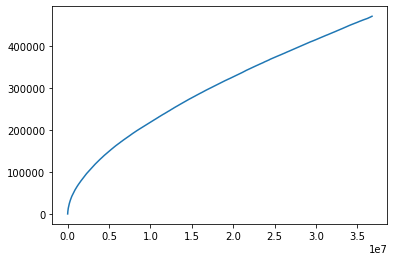

In [69]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
plt.show()

# Ответьте на следующие вопросы:
### какое слово встречается чаще, "сотрудник" или "клиент"?
### сколько раз встречается слова "мошенничество" и "доверие"?

In [71]:
print(popular_words['сотрудник'])
print(popular_words['клиент'])

6472
5432


In [74]:
if (popular_words['сотрудник']) > (popular_words['клиент']):
    print ("встречается чаще слово сотрудник")
elif (popular_words['сотрудник']) < (popular_words['клиент']):
    print ("встречается чаще слово клиент")

встречается чаще слово сотрудник


In [76]:
if (popular_words['мошенничество']) > (popular_words['доверие']):
    print ("встречается чаще слово мошенничество")
elif (popular_words['мошенничество']) < (popular_words['доверие']):
    print ("встречается чаще слово доверие")

встречается чаще слово мошенничество


## В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [89]:
df = df[df['rating_grade'].notna()]

In [101]:
data = df[(df['rating_grade'] == 5) | (df['rating_grade'] == 1)]

In [111]:
from sklearn.model_selection import train_test_split

In [112]:
x_train, x_test, y_train, y_test = train_test_split(data.text, data.rating_grade)

In [115]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

In [116]:
vec = TfidfVectorizer()
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.99      0.96      0.98     12176
         5.0       0.88      0.98      0.93      3349

    accuracy                           0.97     15525
   macro avg       0.94      0.97      0.95     15525
weighted avg       0.97      0.97      0.97     15525



## Часть 2. Тематическое моделирование

In [119]:
from gensim.models import lsimodel
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

In [154]:
df = pd.DataFrame(responses)
df["text"] = df["text"].str.lower()

In [146]:
texts = [text.split() for text in df.text]

In [147]:
dictionary = Dictionary(texts)

In [149]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [150]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [151]:
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

In [152]:
lsi.show_topics(5)

[(0,
  '0.126*"-" + 0.117*"я" + 0.112*"мне" + 0.089*"меня" + 0.088*"деньги" + 0.082*"о" + 0.082*"все" + 0.081*"у" + 0.079*"за" + 0.079*"это"'),
 (1,
  '-0.172*"-" + 0.152*"заявление" + -0.130*"вклад" + 0.128*"г." + 0.113*"руб." + 0.105*"денежных" + 0.102*"средства" + 0.101*"000" + 0.100*"денежные" + 0.099*"средств"'),
 (2,
  '0.239*"звонки" + -0.204*"банкомат" + 0.198*"кредит" + -0.188*"деньги" + -0.168*"карту" + -0.155*"карты" + 0.147*"номер" + 0.122*"мой" + -0.122*"карта" + 0.113*"вашего"'),
 (3,
  '0.253*"номер" + -0.212*"кредит" + 0.193*"звонки" + -0.164*"000" + -0.147*"кредита" + -0.144*"руб." + -0.138*"сумму" + 0.131*"телефона" + -0.118*"сумма" + 0.115*"карта"'),
 (4,
  '0.200*"вклад" + -0.196*"кредит" + 0.181*"вклада" + -0.118*"сказали," + -0.118*"мы" + 0.110*"средств" + 0.100*"денежных" + -0.095*"она" + -0.094*"нам" + 0.093*"–"')]

## в первую тему пошли местоимения, в вторую вопросы связанные с вкладами\деньгами, в третью вопросы по звонкам, в четвертую и пятую вопросы по картам и звонкам

## Часть 3. Классификация текстов

In [155]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD


# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])



clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])


In [169]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [156]:
data = df[(df['rating_grade'] == 5) | (df['rating_grade'] == 1)]

In [157]:
x_train, x_test, y_train, y_test = train_test_split(data.text, data.rating_grade)

In [159]:
clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
]) 
    
clf.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('tm', TruncatedSVD()), ('clf', RandomForestClassifier())])

In [166]:
y_pred = clf.predict(x_test)

In [167]:
accuracy_score(y_test, y_pred)

0.8096618357487922

In [170]:
f1_score(y_test, y_pred)

0.8792053304991212

In [182]:
clf = Pipeline([ 
    ('vect', CountVectorizer(ngram_range=(2,2))), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
]) 
    
clf.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(2, 2))),
                ('tfidf', TfidfTransformer()), ('tm', TruncatedSVD()),
                ('clf', RandomForestClassifier())])

In [183]:
y_pred = clf.predict(x_test)

In [184]:
accuracy_score(y_test, y_pred)

0.816682769726248

In [185]:
f1_score(y_test, y_pred)

0.8851307717145626

In [186]:
clf = Pipeline([ 
    ('vect', CountVectorizer(ngram_range=(2,2))), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
]) 
    
clf.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(2, 2))),
                ('tfidf', TfidfTransformer()), ('tm', TruncatedSVD()),
                ('clf', RandomForestClassifier())])

In [187]:
y_pred = clf.predict(x_test)

In [188]:
accuracy_score(y_test, y_pred)

0.81829307568438

In [189]:
f1_score(y_test, y_pred)

0.8860432235911937